In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import zipfile
from tifffile import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2023-04-27 17:31:46.192639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## CSPB 3202 - Artificial Intelligence - HW 5 Yoshie Bell-Souder
<figure><IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=40 ALIGN="right">
</figure>

## Histopathologic Cancer Detection

## 1. Dataset Information
### Dataset source

This dataset is available from the following kaggle competition:
https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

<b>Description:</b> The goal of this project is to build and train convolutional neural networks that can classify pathology images.

### Dataset size and features

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue
Images are grouped into three sets for training, and testing. Here is a summary of the dataset's contents:

- train/: 6.15 GB size, 277484 total labeled images for model training.
- test/: 1.61 GB size, 220025 total labeled images for model testing.
- sample_submission.csv: 2.5 MB size, 57458 total id and label for predicting.
- train_labels.csv: 9.5 MB size, 220025 total id and label.

Loading the dataset

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [29]:
# Get files
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
train_data = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
test_data = pd.read_csv('histopathologic-cancer-detection/sample_submission.csv')

## 2. Exploratory data analysis (EDA)
### 2.1 EDA
The dataset contains 220025 images. There are 130908 non-milignant and 89117 are malignant images.

training batch dimensions:(220025, 2)
testing batch dimensions:(57458, 2)

In [4]:
#Preview what the train data look like
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
#Check training dataset size
train_data.shape

(220025, 2)

In [6]:
#Check training dataset detail(how many non-milignant vs 1:milignant)
train_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [7]:
#Check test dataset size
test_data.shape

(57458, 2)

In [8]:
#Preview what the test data look like
test_data.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [9]:
#Check duplication item, if found, removed it. But it seems none
train_data[train_data.duplicated(keep=False)]

,id,label


In [10]:
#Check N/A item, if found, removed it. But it seems none
nan_in_col  = train_data[train_data['label'].isna()]
print(nan_in_col )

Empty DataFrame
Columns: [id, label]
Index: []


### The dataset looks already well cleaned. I could not find any duplicate and N/A Data.

### 2.2 EDA: distribution of the non/milignant data

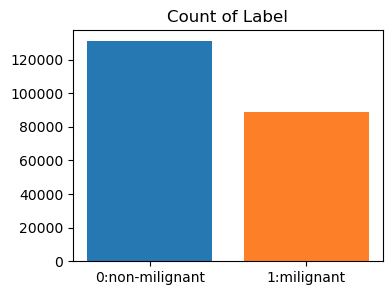

In [33]:
#create bar plot
x = ["0:non-milignant", "1:milignant"]
y = [train_data['label'].value_counts()[0], train_data['label'].value_counts()[1]]
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Count of Label')
# drawing the plot
plt.bar(x,y,color=['#2678b2', '#fd7f28'])
plt.show()

### we have about a 60 / 40 split of non-milignant and milignant samples in the data. 

([<matplotlib.patches.Wedge at 0x7fc4f5f334c0>,
 [Text(-1.051404079333815, -0.3233410922852414, '0:non-milignant'),
  Text(1.1469863013896602, 0.3527356296498388, '1:milignant')],
 [Text(-0.5734931341820808, -0.17636786851922254, '59.5%'),
  Text(0.6690753424773016, 0.2057624506290726, '40.5%')])

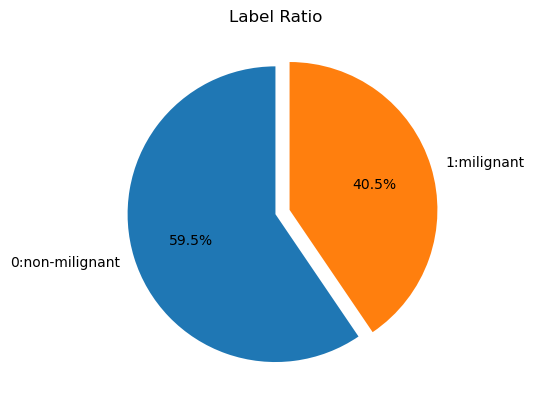

In [32]:
#create pie chart
labels = '0:non-milignant', '1:milignant'
sizes = [train_data['label'].value_counts()[0]/220025, train_data['label'].value_counts()[1]/220025]
fig, ax = plt.subplots()
ax.set_title('Label Ratio')
myexplode = [0, 0.1]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode = myexplode)

### 2.3 Loading Actual Data, and examine color distribution

0:non-milignant, 1:milignant


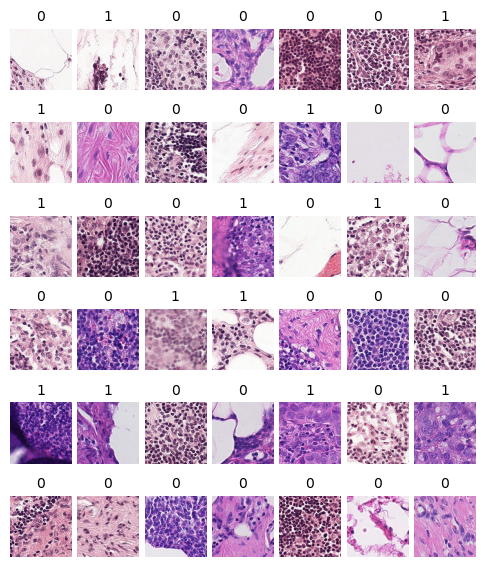

In [30]:
images_train = train_data
images_train['label'] = images_train['label'].astype(str)
images_train['id'] = train_data['id'] + '.tif'

rows, cols = 6, 7

fig, axes = plt.subplots(rows, cols, figsize=(rows, cols))

for i in range(rows * cols):
    image = imread(train_path + images_train['id'][i])
    title_label = images_train['label'][i]
    row, col = i // cols, i % cols

    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(title_label,fontsize = 10)

plt.subplots_adjust(wspace = 0.1, hspace = 0.3)
print("0:non-milignant, 1:milignant")
plt.show()

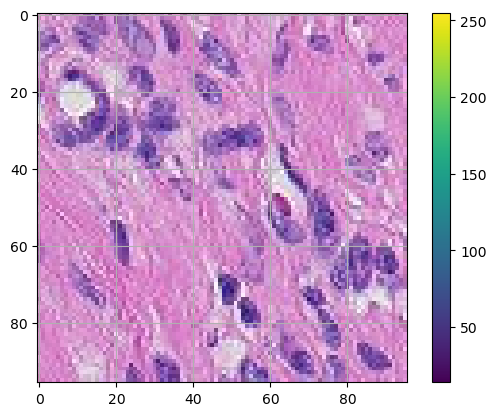

In [31]:
plt.imshow(image)
plt.colorbar()
plt.grid(True)
plt.show()

### 2.4 Split the training dataset to prepare the predection

In [11]:
# Split the data set
y = train_data['label']
x_train, x_valid = train_test_split(train_data, test_size=0.2, random_state=45, 
                                      stratify=y)

print("Train Dataset", x_train.shape)
print("Test Dataset", x_valid.shape)

Train Dataset (176020, 2)
Test Dataset (44005, 2)


In [12]:
# prepare data for training
def append_tif(string):
    return string+".tif"

x_train['id'] = x_train['id'].apply(append_tif)
x_valid['id'] = x_valid['id'].apply(append_tif)
test_data['id'] = test_data['id'].apply(append_tif)
y_valid = x_valid['label']

### 2.5 Plan of analysis
Importing and using Keras library we learn at week12, we will evaluate the model

In [13]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Dropout
from keras.optimizers import Adam

## 3. architecture model 

We will now focus on creating a simple model for this by using the Keras library. Adjustment how many layers we need, and their types, I used as a reference(https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook).

First I normalized the images before training, then output layer activation. Using the Adam library of Keras, I optimized the image.

Next, full layers are defined using the Dense class and hidden layer activations(ReLu). The class is flexible in the number of nodes in the layer as the first argument. Because ReLU is rectified linear unit activation function.

Last, We drop out and use the Sigmoid function in the output layer.

In [14]:
# set model constants
BATCH = 256

In [15]:
# normalizing it and split data into training and validation sets
test_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

In [16]:
test_loader = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = test_path,
    x_col = 'id',
    batch_size = BATCH,
    shuffle = False,
    class_mode = None,
    target_size = (64,64)
)


valid_loader = valid_datagen.flow_from_dataframe(
    dataframe = x_valid,
    directory = train_path,
    x_col = 'id',
    batch_size = BATCH,
    shuffle = False,
    class_mode = None,
    target_size = (64,64)
)

Found 57458 validated image filenames.
Found 44005 validated image filenames.


In [17]:
# Setup GPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [19]:
# set ROC AUC as metric
ROC_1 = tf.keras.metrics.AUC()

# use GPU
with strategy.scope():kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (64, 64, 3))) # original image = (96, 96, 3) 
model.add(BatchNormalization())
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(BatchNormalization())
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(BatchNormalization())
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(dropout_dense))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))

model.build(input_shape=(256, 64, 64, 3))
model.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])

model.summary()

2023-04-27 17:32:22.018332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 32)       1

### 4. Results
we have trained the model, we can take at look at how it did graphically with the training data. I will show the accuracy and loss with regards to the validation and training set below.

In [21]:
test_probability = model.predict(test_loader, verbose=1)

225/225 [==============================] - 296s 1s/step


In [22]:
# Preview 10 sample prediction
print(test_probability.shape)

(57458, 2)


In [23]:
print(test_probability[:10,].round(2))

[[0.39 0.31]
 [0.39 0.31]
 [0.39 0.31]
 [0.39 0.31]
 [0.39 0.31]
 [0.39 0.31]
 [0.39 0.31]
 [0.39 0.31]
 [0.39 0.31]
 [0.39 0.31]]


In [24]:
valid_probs = model.predict(valid_loader, verbose=1)

172/172 [==============================] - 171s 989ms/step


In [25]:
print(valid_probs.shape)
valid_pred = np.argmax(valid_probs, axis=1)
print(valid_pred[:10])

(44005, 2)
[0 0 0 0 0 0 0 0 0 0]


In [27]:
cm = confusion_matrix(y_valid, valid_pred)
pd.DataFrame(cm, index=['True No', 'True Has'], 
            columns=['Predictiction No', 'Prediction Has'] )

,Predictiction No,Prediction Has
True No,26182,0
True Has,17823,0


In [28]:
print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.59      1.00      0.75     26182
           1       0.00      0.00      0.00     17823

    accuracy                           0.59     44005
   macro avg       0.30      0.50      0.37     44005
weighted avg       0.35      0.59      0.44     44005



/Users/yoshie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoshie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoshie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5. conclusion
- We can see 44005 sample is correctly predicted as No cancer, and 0 samples is correctly predicted as Has Cancers.
- I tried multi times, mulity ways, but I could not figure it out why the result happens during homework due.
- Considering f1 score, the result is not too bad.

### Referrences
- tensorflow and keras tutorial: https://www.tensorflow.org/tutorials
- https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
- pretrained keras model: https://keras.io/api/applications/
- Visualizing Colors in Images Using Histogram: https://www.geeksforgeeks.org/visualizing-colors-in-images-using-histogram-in-python/
- https://towardsdatascience.com/neural-network-architectures-156e5bad51ba